In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
# Set plot style
sns.set(style='whitegrid')


In [18]:
# df = pd.read_csv("../data/raw/MachineLearningRating_v3.txt",
#                  on_bad_lines='warn')
# Open the file and read the first line
# with open("../data/raw/MachineLearningRating_v3.txt", "r") as f:
#     header_line = f.readline().strip()  # strip removes newline at the end

# # Split the line using the pipe delimiter
# column_names = header_line.split('|')

# # Print number of columns and their names
# print(f"Total columns: {len(column_names)}")
# for i, col in enumerate(column_names, start=1):
#     print(f"{i}. {col}")
df = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep='|', low_memory=False)

# Save as a CSV file
df.to_csv("ml_ratings.csv", index=False)


####   Data Overview 


In [17]:

print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Descriptive Statistics ---")
print(df.describe(include='all'))


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Provi

#### Data Quality Checks

In [19]:

print("\n--- Missing Values ---")
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


--- Missing Values ---
NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
Rebuilt                     641901
Converted                   641901
WrittenOff                  641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8259
VehicleType                    552
make                           552
mmcode                         552
Model                          552
Cylinders                      552
bodytype                       552
kilowatts                      552
NumberOfDoors                  552
VehicleIntroDate               552
cubiccapacity                  552
CapitalOutstanding               2
dtype: int64


In [25]:
# Check for problematic values
print("Negative TotalClaims:", (df['TotalClaims'] < 0).sum())
print("Negative TotalPremium:", (df['TotalPremium'] < 0).sum())
print("Negative CustomValueEstimate:", (df['CustomValueEstimate'] < 0).sum())

print("Missing values:")
print(df[['TotalClaims', 'TotalPremium', 'CustomValueEstimate']].isnull().sum())


Negative TotalClaims: 2
Negative TotalPremium: 0
Negative CustomValueEstimate: 0
Missing values:
TotalClaims                 0
TotalPremium                0
CustomValueEstimate    462076
dtype: int64


In [26]:
# Keep only valid (non-negative and non-null) values for log transformation
df = df[df['TotalClaims'].notnull() & (df['TotalClaims'] >= 0)]
df = df[df['TotalPremium'].notnull() & (df['TotalPremium'] >= 0)]
df = df[df['CustomValueEstimate'].notnull() & (df['CustomValueEstimate'] >= 0)]

# Now apply log1p safely
df['LogTotalClaims'] = np.log1p(df['TotalClaims'])
df['LogTotalPremium'] = np.log1p(df['TotalPremium'])
df['LogCustomValueEstimate'] = np.log1p(df['CustomValueEstimate'])


####  Feature Engineering

In [27]:

df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']


####  Univariate Analysis

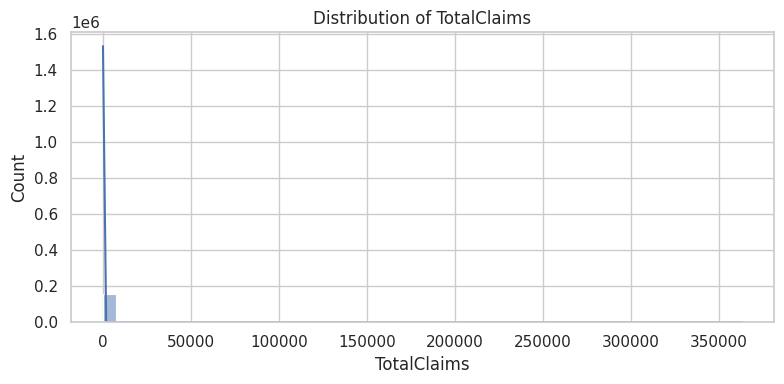

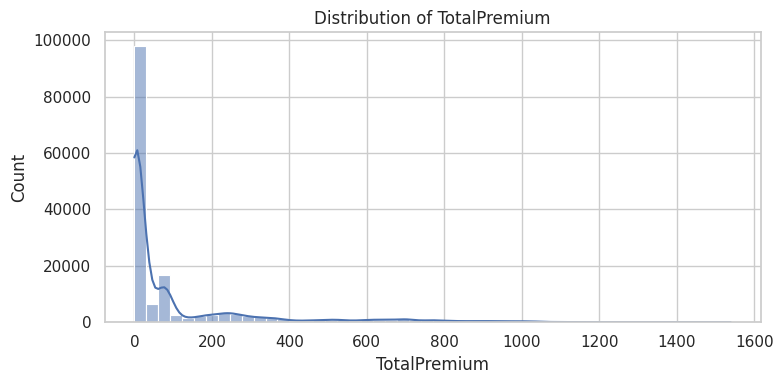

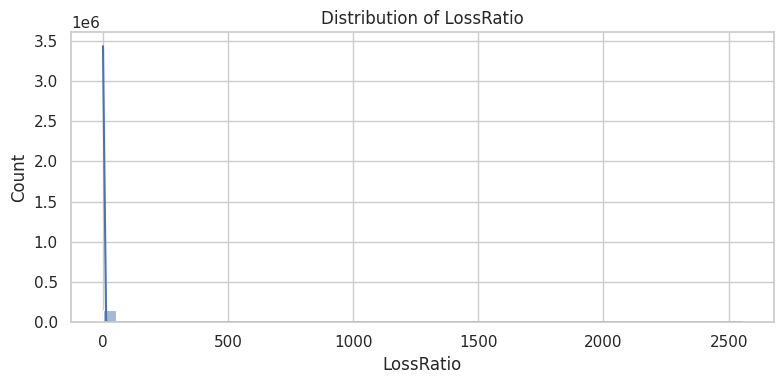

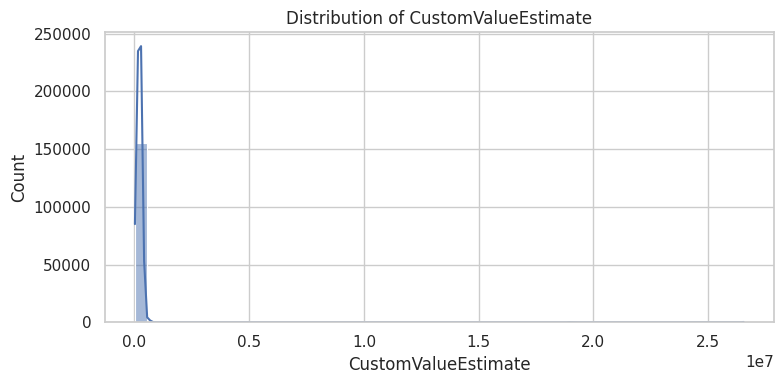

In [28]:

numerical_cols = ['TotalClaims', 'TotalPremium', 'LossRatio', 'CustomValueEstimate']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

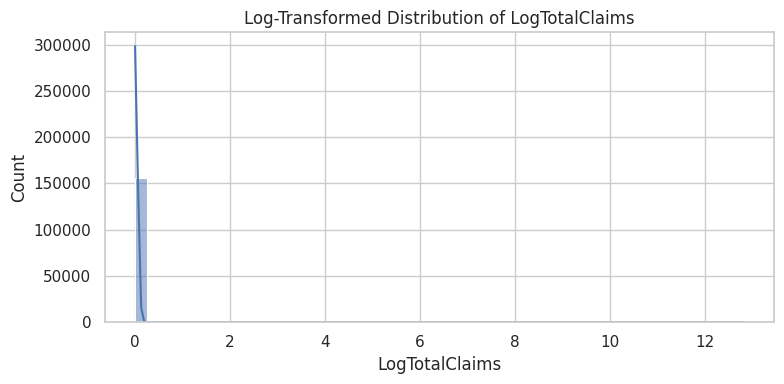

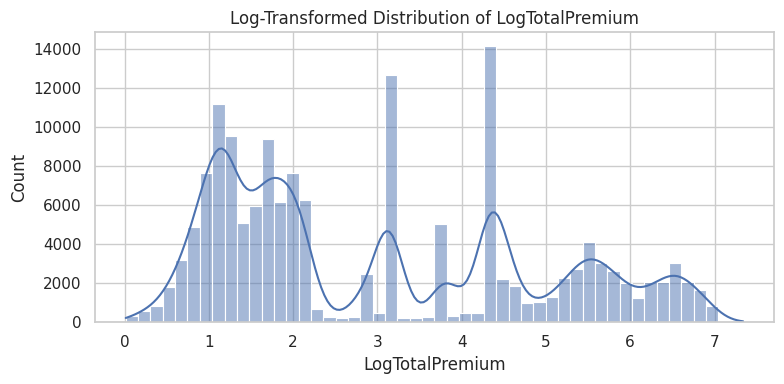

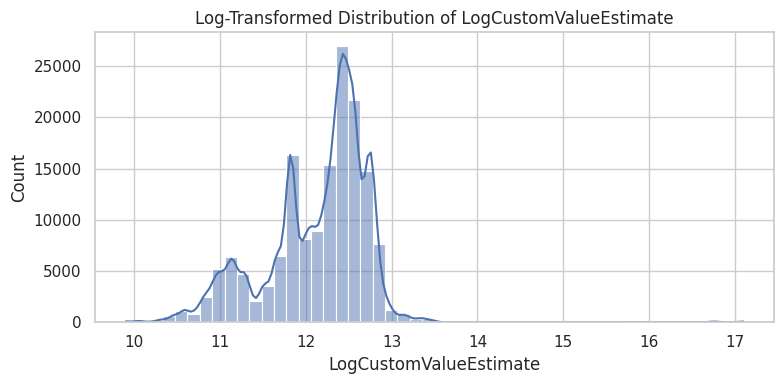

In [29]:
# --- Log Transformation to Reduce Skew ---

import numpy as np

# Apply log1p (log(x + 1)) to avoid issues with 0 values
df['LogTotalClaims'] = np.log1p(df['TotalClaims'])
df['LogTotalPremium'] = np.log1p(df['TotalPremium'])
df['LogCustomValueEstimate'] = np.log1p(df['CustomValueEstimate'])

# Optional: Recalculate LossRatio after handling zero division
df = df[df['TotalPremium'] > 0]
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']

# Plot log-transformed distributions
log_cols = ['LogTotalClaims', 'LogTotalPremium', 'LogCustomValueEstimate']
for col in log_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Log-Transformed Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


#### Categorical Analysis 

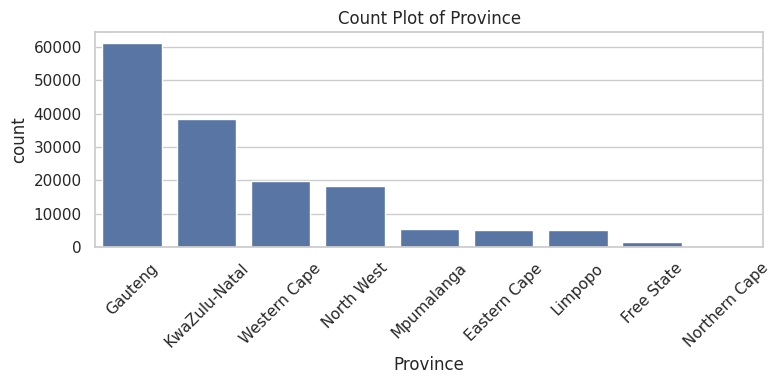

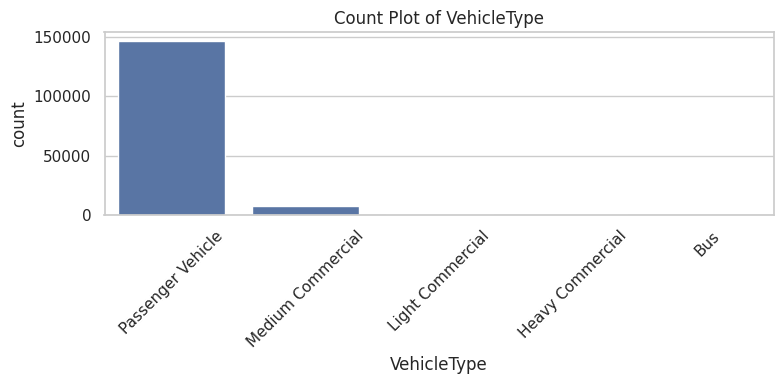

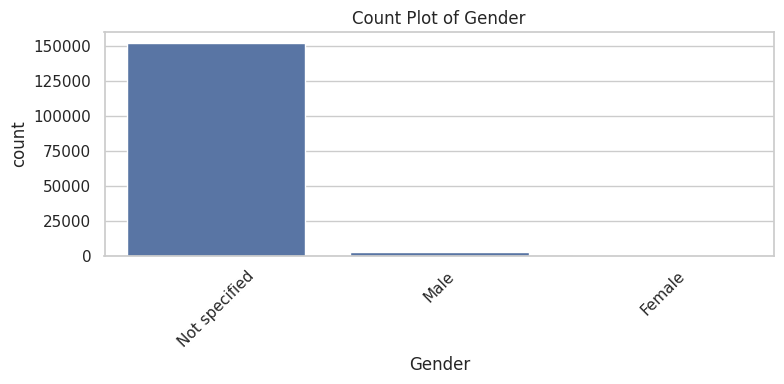

In [30]:

categorical_cols = ['Province', 'VehicleType', 'Gender']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Bivariate Analysis 
####  Loss Ratio by Province

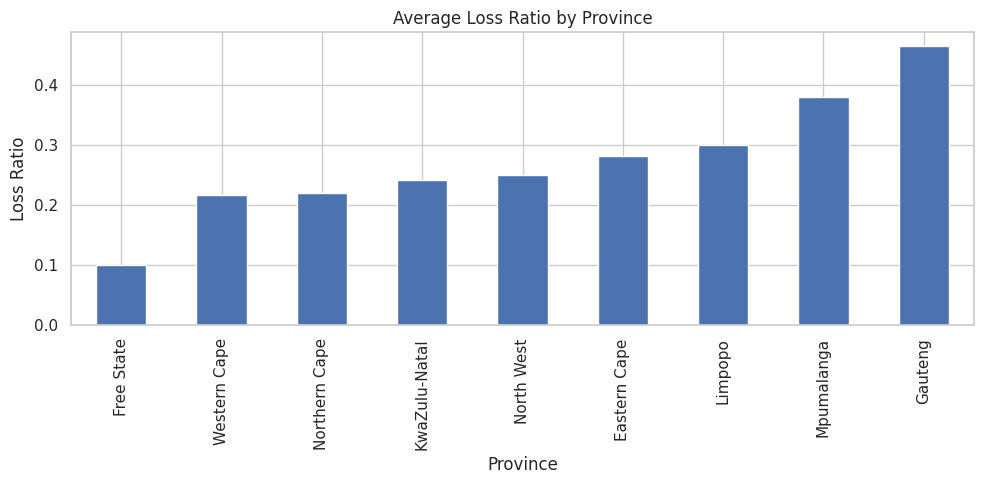

In [31]:

plt.figure(figsize=(10, 5))
df.groupby('Province')['LossRatio'].mean().sort_values().plot(kind='bar')
plt.title('Average Loss Ratio by Province')
plt.ylabel('Loss Ratio')
plt.tight_layout()
plt.show()


#### Total Claims vs Total Premium

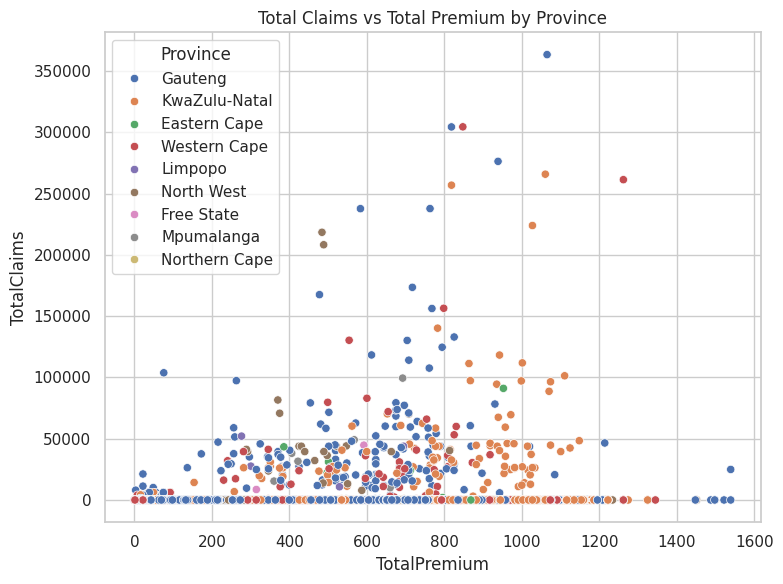

In [32]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TotalPremium', y='TotalClaims', hue='Province')
plt.title('Total Claims vs Total Premium by Province')
plt.tight_layout()
plt.show()

#### Correlation heatmap

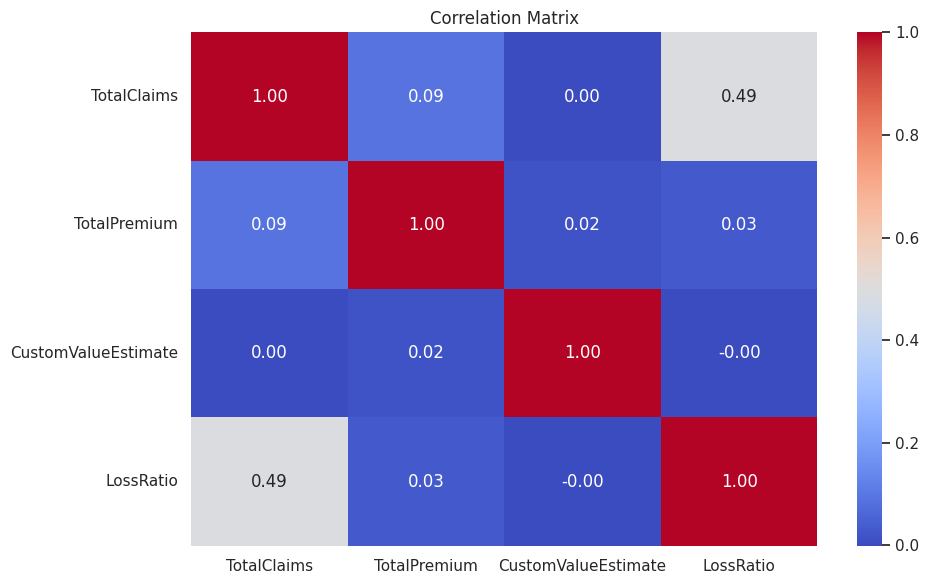

In [33]:

plt.figure(figsize=(10, 6))
corr_matrix = df[['TotalClaims', 'TotalPremium', 'CustomValueEstimate', 'LossRatio']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

####  Outlier Detection 

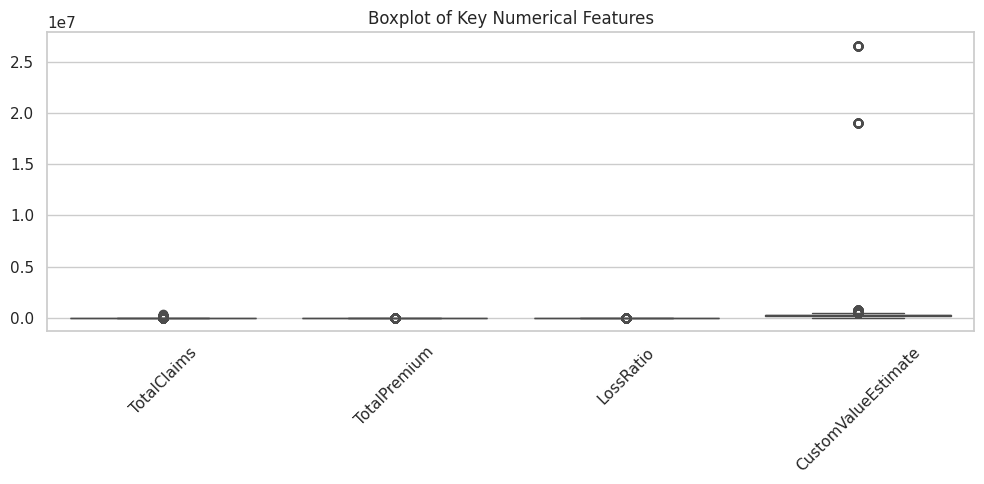

In [34]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=df[numerical_cols])
plt.title('Boxplot of Key Numerical Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#####  Save a processed summary

In [37]:

summary = df[['Province', 'VehicleType', 'Gender', 'TotalClaims', 'TotalPremium', 'LossRatio']]
summary.to_csv("../data/processed/summary_stats.csv", index=False)

print("EDA complete. Summary file saved to: data/processed/summary_stats.csv")


EDA complete. Summary file saved to: data/processed/summary_stats.csv
